<a href="https://colab.research.google.com/github/zen030/tech_review/blob/master/tech_review_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using BERT
###### zainalh2@illinois.edu

## 1. Introduction
This document illustrates the use of the BERT pre-trained model to classify the sentiment of Twitter tweets.

The target audience of the document:
<ol>
<li>The audience who has <i><b>no experience in BERT pre-training Model</b></i>.</li>
<li>The audience who has the curiosity on how to use and fine-tune the BERT model for simple training tasks such as text classification (categorization).</li>
<li>The audience who has some basic understanding of Data Mining and Machine Learning.</li>
<ul>
<li> Understand the concept of Text Mining.</li>
<li> Understand the concept of Training and Validation datasets</li>
<li> Understand the concept of F1-Score evaluation</li>
</ul>
<li>The audience who have basic knowledge of Python 3, PyTorch usage, and Jupyter Notebook.</li>
<li>And of course, the audience who is looking forward to spending fun time with Python code!</li>
</ol>

The main sources of inpiration of this document are the following Internet sources:
<ol>
<li>Cousera course: https://www.coursera.org/learn/sentiment-analysis-bert/home/welcome</li>
<li>An article: https://mccormickml.com/2019/07/22/BERT-fine-tuning/</li>
</ol>

I try to combine BERT implementation and concept from both sources into a single document. I hope this document will be useful for everyone who is new to BERT world!

## 2. What is BERT and Text Sentiment Analysis?
### 2. 1. What is BERT?
BERT is <i><b>Bidirectional Encoded Representations from Transformer</b></i> is a Natural Processing Language (NLP) pre-training model developed by Google (https://en.wikipedia.org/wiki/BERT_(language_model)). 

This means BERT provides a "base" model that is already trained using large number of text corpus. Luckily Google folks had already did this for us, and they shared the model to the world for us to use for free! Hundreds of GPU hours needed to train the original base BERT model.

Useful Internet sources to understand BERT:
1.	BERT for dummies: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
2.	The Illustrated BERT: http://jalammar.github.io/illustrated-bert/
3.	The BERT original paper:  https://arxiv.org/abs/1810.04805.

### 2. 2. What is Text Sentiment analysis?

Text Sentiment Analysis is a study in Text Mining to systematically identify, extract, quantify and study subjective information in un-structured text data (https://en.wikipedia.org/wiki/Sentiment_analysis).

Imagine we have a “smart” module in which we can feed text data as an input. The “smart” module, implemented as a software code, will be able to output the sentiment found in the text data, as illustrated by the diagram below:

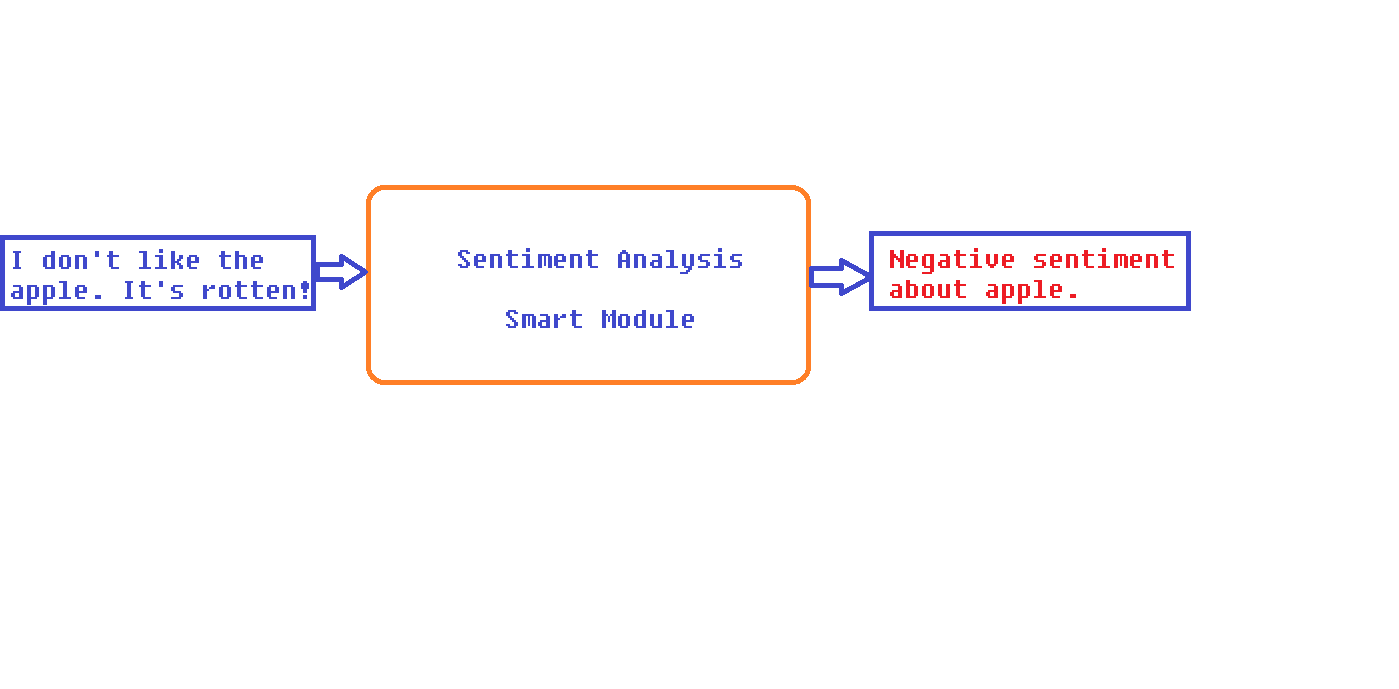





In the illustration above, we pass a text data <b>“I don’t like the apple. It’s rotten!”</b>. We as human can easily identify that the opinion holder expressed his/her negative sentiment about an apple. To us the reason is so obvious that the apple is rotten. But for a computer to understand the sentiment, it requires complex computation model.  We can use BERT to model the computation of the “smart” module to detect sentiment found in text data.

# 3. Case study
This document uses a case study implemented in Software code section to illustrate BERT capability to classify the sentiment found in text data.

The dataset is labelled Twitter tweet. Each label expresses the sentiment of the tweet. In software code, we will split the dataset into training and validation datasets. Training dataset will be used to train base BERT model. Using the trained BERT model, we will use validation dataset to evaluate the accuracy of the trained BERT model.

## 3.1. Dataset
Case study uses dataset which we can freely download from the Internet. 
### 3.1.1. Dataset Source
Dataset is taken from the source:
<ol><li>
Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2
</li></ol>

### 3.1.2. Text structure in the dataset
Before we use and analyze the dataset using BERT, I will describe the data format found in the dataset as follow:

<ol>
<li>
Dataset has 3085 lines (tweets). Each record consists of 3 columns.
<ul>
<li>Column-1: The unique ID of the line/tweet</li>
<li>Column-2: The tweet message</li>
<li>Column-3: The sentiment label of the message (sad, happy, etc.)</li>
</ul>
</li>
<li>
Sample data from the dataset:
611537640857411584,"@britishmuseum @SenderosP The Rosetta Stone ;)",happy
<ul>
<li>Column-1: 611537640857411584</li>
<li>Column-2: "@britishmuseum @SenderosP The Rosetta Stone ;)"</li>
<li>Column-3: happy</li>
</ul>
</li>
</ol>

## 3.2. Software Code
This Jupyter Notebook is also stored in Github: https://github.com/zen030/tech_review/blob/master/tech_review_colab.ipynb

Detail explanation of each step in the software code section is decribed in the comments.

### 3.2.1. Using Google Colab

The software code is implemented and tested using Google Colab environment.

Introduction about this environment can be found here: https://colab.research.google.com/notebooks/intro.ipynb



In [1]:
# Check if the GPU is available in the Colab environment
# To activate GPU, in this Colab Notebook, go to Edit -> Notebook Settings
# And make sure GPU is selected as Hardware Accelerator
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
# Since we are going to use PyTorch and GPU
# We need to tell PyTorch to use GPU explicitly (By default CPU will be used)
import torch

# If GPU is available.
if torch.cuda.is_available():    
    # PyTorch to use the GPU    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If GPU is not available. Use the CPU.
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### 3.2.2. Analyze the dataset using pandas DataFrame

In [3]:
# Load data from file to pandas DataFrame
import pandas as pd  # https://pandas.pydata.org/
# dataframe columns: [id, text, category]. Column id is the index.
df = pd.read_csv('sample_data/smile-annotations-final.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [4]:
# Take a look at first 5 records
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [5]:
# Number of record of each category
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [6]:
# Filter out multiple label (the ones with | character) to the sake of simplicty.
df = df[~df.category.str.contains('\|')]
# Filter out 'nocode' category. 'nocode' does not represent particular sentiment.
df = df[df.category != 'nocode']
# Filter out 'disgust' since it has only 6 records. We need more record to train the model.
df = df[df.category != 'disgust']

In [7]:
# Record counting of each category after data filter
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
Name: category, dtype: int64

In [8]:
# Assign label to each category. Label value is integer.
# Label will be used by the model to classify the text sentiment. 
possible_labels = df.category.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
df['label'] = df.category.replace(label_dict)    

In [9]:
# Review the first 5 records after the new label column added.
df.head()

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


### 3.2.2. Split the dataset into training dataset and validation dataset
Dataset is split with the following distribution:
- 85% as Training dataset: This is used to train the model.
- 15% as Validation dataset: This is used to evaluate the trained model.

In [10]:
# We will use sklearn library to split the dataset into training and validation dataset
from sklearn.model_selection import train_test_split # https://scikit-learn.org/

In [11]:
# Here we split the dataset. The 80% vs 20% data split is considered a fair split.
# However we definitely need to have a bigger data size for training compared to testing dataset.
# Thus the split for our case:
#   1) 80% as training dataset
#   2) 20% as validation dataset
# To choose which one goes to traning or validation dataset, it will be done randomly.
# traing_test_split function will use random_state to randomly choose the dataset.
# random_state set to 42. Popular integer random seeds are 0 and 42.
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [12]:
# Adding a new column called "data_type".
# this is to label each text record either it is "train"-ing dataset
# or "val"-idation dataset 
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

# print dataframe to see the first 5 records
df.head()

,text,category,label,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,train
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,val
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,train
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,train
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,train


In [13]:
# Verify the data distribution by category and data_type.
# Here we should have 80% vs 20% distribution for each category & data_type.
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        45
                   val          12
happy        0     train       910
                   val         227
not-relevant 1     train       171
                   val          43
sad          3     train        26
                   val           6
surprise     4     train        28
                   val           7

### 3.2.2. Tokenizing and Encoding
Tokenization in BERT is another interesting topic to explore. BERT uses WordPiece tokenization strategy. 

Internet sources to explore this topic further:
- Original paper: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf
- An article about BERT Token Embedding: https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a

In [14]:
# We will use Huggingface library to instatiate transformers.
# Reference about Huggingface transformers: https://github.com/huggingface/transformers
# By default Google Colab does NOT have transformers installed.
# The command below will install transformers
!pip install transformers

In [15]:
from transformers import BertTokenizer # https://huggingface.co/transformers/model_doc/bert.html
from torch.utils.data import TensorDataset # https://pytorch.org/
import torch

In [16]:
# we create our BERT tokenizer.
# this will create WordPiece tokenizer which is required by BERT model.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [17]:
# Before we move on to the next, we should have one check done.
# This check will help us decide on how to encode our text data (details below).
df.text.str.len().max()

149

In [18]:
# This part is all about preparing our data!
# We encode our data into a format that BERT model can understand.
# It will add special tokens to the text data: [CLS] and [SEP]
# It will add special [PAD] token after [SEP] in each text record.
# Why? Because BERT accepts fixed-length data with maximum 512 token.
# In our case, max_length is set to 152 considering maximum length of our text data is 149
# return_tensors='pt' means we are preparing our encoded data for PyTorch
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    max_length = 152,
    padding='max_length',
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True,     
    max_length = 152,
    padding='max_length',
    return_tensors='pt'
)


# BERT id representation for each token 
# input_ids_*

# Attention mask to differiantiate between token data and padding [PAD] token
# mask = 1 for token data
# mask = 0 for padding [PAD] token
# attention_masks_*

# create tensor for the category label
# labels_*

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [19]:
# Let's take a look at our text data in a BERT encoded representation!
# This is how BERT model "see" our text data.
encoded_data_train

{'input_ids': tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
        [  101,  1030, 10682,  ...,     0,     0,     0],
        [  101,  1030,  2329,  ...,     0,     0,     0],
        ...,
        [  101,  1523,  1030,  ...,     0,     0,     0],
        [  101,  1030,  3680,  ...,     0,     0,     0],
        [  101,  1030,  2120,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [20]:
# Create the Tensor dataset. We will pass this tensor datasets to data loader.
# For more details about data loader, carry on to the next sections.
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

### 3.2.2. Setting Pre-Trained BERT Model

The original BERT paper presented two model sizes:
- BERT BASE: 12 Encoder Layers
- BERT LARGE: 24 Encoder Layers
This case study uses base-uncased model (uncased means all the character in the text data are treated as lower case characters).

In [21]:
# For complete list of BERT Model available in huggingface: https://huggingface.co/models
from transformers import BertForSequenceClassification

In [22]:
# Here, we will use a pre-tained BERT model BertForSequenceClassification
# BertForSequenceClassification is basically BERT Base model with different top layers
# and output types designed to accomodate specific NLP task such as classification task.
# More detail about BertForSequenceClassification: https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# device in current case is set to GPU
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 3.2.2. Creating Data Loaders
Data loader is responsible to pass a batch of data (TensorDataset) to the model to process.

In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [24]:
# Number of text records pass to the model at the same batch
# batch_size=32 is recommended in the BERT original paper
batch_size = 32 

# Create data loader for training TensorDataset
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
# Create data loader for validation TensorDataset
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

### 3.2.2. Setting Up Optimiser and Scheduler

In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [26]:
# Optimizer in a nutshell is the algorithm to speedup the model learning process (training cost reduction at higher speed).
# For more detail about optimizer: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

# For the purposes of fine-tuning, it is recommend choosing from the following values:
#   1. Learning rate (Adam): 5e-5, 3e-5, 2e-5
#   2. The epsilon parameter eps = 1e-8 is a very small number to prevent any division by zero in the implementation.
# This is the recommendation from BERT original paper.

optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  eps=1e-8)

In [27]:
# Recommended to have 2, 3 or 4 EPOCHS for fine-tuning BERT on a specific NLP task.
# This is the recommendation from BERT original paper.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# Create the learning rate scheduler. Reference: https://huggingface.co/transformers/main_classes/optimizer_schedules.html
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

### 3.2.2. Defining Performance Metrics

In [28]:
import numpy as np
from sklearn.metrics import f1_score

# Function to calculate F1 score: https://en.wikipedia.org/wiki/F-score
# F1 score is harmonic mean of the precision and recall
def calculate_f1_score(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

# Function to calculate accuracy per category.
def accuracy_per_category(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

### 3.2.2. Creating our Training Loop

This training code is based on the `run_glue.py` script here: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

In [29]:
# Helper function to evaluate the validation result from the trained model
def evaluate(dataloader_val):
    # To set the model into a training mode
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():     
            # evaluate the validation dataset   
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [30]:
from tqdm.notebook import tqdm # https://github.com/tqdm/tqdm
import random

# The random seed used to initialise the weights 
# and select the order of the training data.
# Set the seed value all over the place to make this reproducible.
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# loop over the full dataset for a number of epochs times
for epoch in tqdm(range(epochs)):
    
    # To set the model into a training mode
    model.train()
    
    # Measure the total training loss for each epoch
    loss_train_total = 0
    # Progressbar to show the progress of the current epoch
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    # Process each batch in the current epoch
    for batch in progress_bar:

        # Always clear any previously calculated gradients before performing a backward pass. 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()
        
        # Unpack current training batch.
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        # This is the actual learning
        outputs = model(**inputs)
        
        # Current training loss
        loss = outputs[0]
        # Current total training loss
        loss_train_total = loss_train_total + loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    # Save the trained BERT model for the current epoch iteration    
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    loss_train_avg = loss_train_total/len(dataloader_train)            
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = calculate_f1_score(predictions, true_vals)

    # Report the summary of epoch iteration
    tqdm.write(f'\nEpoch {epoch}')
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 0
Training loss: 0.9385107320708197
Validation loss: 0.6466381788253784
F1 Score (Weighted): 0.7314488234202776



Epoch 1
Training loss: 0.6040981573027533
Validation loss: 0.4958310484886169
F1 Score (Weighted): 0.7769332452081957



Epoch 2
Training loss: 0.4714568764776797
Validation loss: 0.4410941883921623
F1 Score (Weighted): 0.7949400259557755



Epoch 3
Training loss: 0.38135904718089747
Validation loss: 0.43996200487017634
F1 Score (Weighted): 0.8077848630778315



### 3.2.2. Evaluate the trained model

In [31]:
# Validate all the trained BERT model (for each EPOCH)
for _, epoch in enumerate(range(epochs)):
  tqdm.write(f'EPOCH: {epoch}')
  model.load_state_dict(torch.load('finetuned_BERT_epoch_{0}.model'.format(epoch), map_location=torch.device('cpu')))
  _, predictions, true_vals = evaluate(dataloader_validation)
  accuracy_per_category(predictions, true_vals)
  tqdm.write(f'########################################################################')

EPOCH: 0
Class: happy
Accuracy: 227/227

Class: not-relevant
Accuracy: 9/43

Class: angry
Accuracy: 0/12

Class: sad
Accuracy: 0/6

Class: surprise
Accuracy: 0/7

########################################################################
EPOCH: 1
Class: happy
Accuracy: 217/227

Class: not-relevant
Accuracy: 23/43

Class: angry
Accuracy: 0/12

Class: sad
Accuracy: 0/6

Class: surprise
Accuracy: 0/7

########################################################################
EPOCH: 2
Class: happy
Accuracy: 219/227

Class: not-relevant
Accuracy: 26/43

Class: angry
Accuracy: 0/12

Class: sad
Accuracy: 0/6

Class: surprise
Accuracy: 0/7

########################################################################
EPOCH: 3
Class: happy
Accuracy: 221/227

Class: not-relevant
Accuracy: 28/43

Class: angry
Accuracy: 0/12

Class: sad
Accuracy: 0/6

Class: surprise
Accuracy: 0/7

########################################################################


# 4. Summary

This case study demonstrates that we can use a pre-trained BERT model to quickly create a model with minimal effort and training time using the pytorch interface.

Let us consider the accuracy result of EPOCH # 3:
- happy: 221/227
- not-relevant: 28/43
- angry: 0/12
- sad: 0/6
- surprise: 0/7

'happy' category has the best result. The model can clasify the 221 sentiment out of 227 tweets.

'not-relevant' has less accuracy but it improves over the EPOCH iterations.
The trained model doesn't give good result/accuracy for the 'angry', 

'sad', and 'suprise' categories. The fact the training and validation dataset for these categories is a lot less than the other categories might be the major factor.

This we can see that BERT can be trained and performed better with a larger corpus.